In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase, floatX

In [3]:
inp = tf.placeholder(floatX, [None, 2])

In [4]:
flow = NVPFlow(2, 'init_flow')(inp)

for i in range(0, 16):
    if i != 0:
        flow = NVPFlow(name='dense_' + str(i))(flow)
    flow = ResFlow(name='res_' + str(i))(flow)
    flow = BNFlow(name='bn_' + str(i))(flow)

In [5]:
flow[-1].output /= 4

In [6]:
flow[-1].logj.shape

TensorShape([])

In [7]:
flows = FlowSequence(flow[1:])

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_47:0' shape=(?,) dtype=float64>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    if hasattr(fl, 'mask'):
        mm += fl.mask

In [11]:
mm

array([16, 16])

In [12]:
with tf.name_scope('gain_scope'):
    z = flows[-1].output
    gain = tf.reduce_sum(-(z*z)/2, axis=-1) + logj
    gain = tf.reduce_mean(gain)

In [13]:
z

<tf.Tensor 'truediv:0' shape=(?, 2) dtype=float64>

In [14]:
train_op = tf.train.AdamOptimizer(0.0001).minimize(-gain)
train_op = [train_op] + flows.ops

In [15]:
X, _ = make_moons(n_samples=1024, noise=0.13)

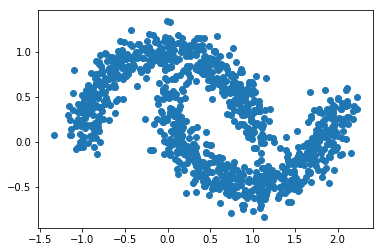

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

-22.787327401793064

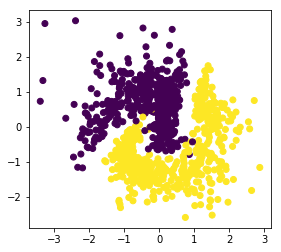

In [33]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [21]:
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [22]:
writer.add_graph(tf.get_default_graph())

In [32]:
for _ in range(400):
    for _ in range(1000):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X})
    print(gain.eval({inp:X}).mean())

-8.151780470137325
-8.117352712472147
-8.184097946711308
-8.075916594880004
-8.142395984837945
-8.10711271549566
-8.111193864964624
-8.09253339803114
-8.112240871083952
-8.108838123422647
-8.123299763272193
-8.116398532158776
-8.150610891635303
-8.081751540169066
-8.148359037092556
-8.044786101599698
-8.12794112988522
-8.070576107739079
-8.145700653229264
-8.166352381121584
-8.074370221640647
-8.111271846654795
-8.138611158315877
-8.084129568614449
-8.078344980252362
-8.110181919031412
-8.113639327763401
-8.051674316820526
-8.099254047323184
-8.083348974031576
-8.11459485574769
-8.11007388402383
-8.08554937002533
-8.096521738309638
-8.137749057984308
-8.126908793781075
-8.124581774160948
-8.149329066855124
-8.094101061984189
-8.093843524149403
-8.113516488395922
-8.169883510573367
-8.07544753982458
-8.066460822653045
-8.393417989498655
-8.109107916806032
-8.07840323651873
-8.120251069466963
-8.077942291187206
-8.108352883313929
-8.098160929958528
-8.133861969533974
-8.125239909050162
-

KeyboardInterrupt: 

In [27]:
inverse = flows.apply(inp*4, inverse=True)

In [34]:
restored = inverse.eval({inp:np.random.normal(size=[400,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [35]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

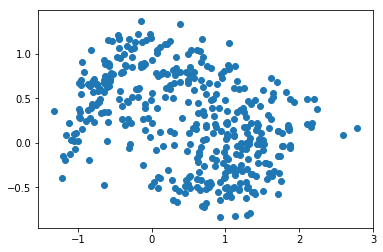

In [36]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()

In [32]:
flows.ops

[]